In [23]:
from enrichment_functions import * 

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from Bio import SeqIO

import json
import gzip

### Parse GO files

In [2]:
# file containing gene ontology
GO_FILE_PATH = "../../data/go.json.gz"

# file containin HUMAN GO annotations
MAP_FILE_PATH = "../../data/goa_human.gaf.gz"

In [3]:
# read ontology file
with gzip.open(GO_FILE_PATH) as f:
    ontology = json.load(f)

# parse ontology
labels, ancestors, min_depth = parse_gene_ontology(ontology)

In [4]:
# Map proteins ID to GO term
protein_to_go = map_protein_to_go(MAP_FILE_PATH)

# Original Dataset

In [5]:
# read the original dataset (hits retrieved by our model)
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()

In [6]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [7]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(background, ancestors, protein_to_go)

In [8]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [9]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [10]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0033277,102.965166,0.000548,4,abortive mitotic cell cycle
0035685,102.965166,0.000548,4,helper T cell diapedesis
0032752,102.958708,0.019147,6,positive regulation of interleukin-3 production
0046544,102.958708,0.019147,4,development of secondary male sexual character...
1903674,102.958708,0.019147,9,regulation of cap-dependent translational init...


In [67]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= 0.05)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
0002343,102.958708,0.019147,3,peripheral B cell selection
0001545,102.958708,0.019147,2,primary ovarian follicle growth
0032633,102.958708,0.019147,3,interleukin-4 production
0002553,68.643402,0.000908,3,histamine secretion by mast cell
0043366,68.643402,0.000908,3,beta selection


In [66]:
result_fisher[filter_terms].tail()

,OddRatio,p-value,depth,label
0046483,0.071278,6.914404e-10,3,heterocycle metabolic process
0006725,0.070181,4.938091e-10,3,cellular aromatic compound metabolic process
0038023,0.068944,1.464697e-05,2,signaling receptor activity
0060089,0.068530,1.482902e-05,1,molecular transducer activity
0034641,0.063728,2.672467e-11,3,cellular nitrogen compound metabolic process


In [74]:
def draw_word_cloud(df, score='OddRatio', N=20):
    """
    Draw first and last N descriptions of df
    """
    #head, tail = df[:N].copy(), df[-N:].copy()
    
    # invert score of tail dataframe
    #tail[score] = 1 / tail[score]
    
    #df_draw = pd.concat([head,tail], ignore_index=True)
    
    wc = WordCloud(background_color='white', width=1600, height=800, max_words=100)
    wc.generate_from_frequencies(
        {line['label']: np.log(1/line[score]) for _, line in df.iterrows()}
    )
    return wc

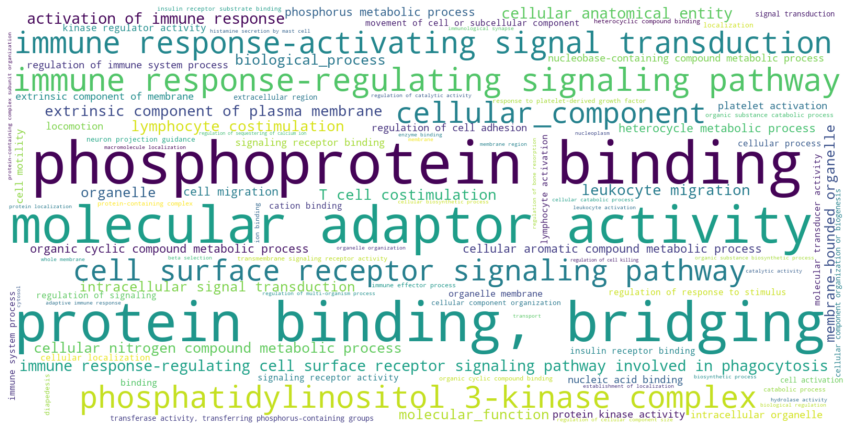

In [75]:
wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = 30,
    score = 'p-value'
)

plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()